In [2]:
import sys
sys.path.insert(0,"../../")

from library import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import *
from bs4.element import PageElement


# Get Page Content

In [3]:
def new_session(headers=None):
    session = requests.Session()
    if headers:
        session.headers.update(headers)
    return session

def get_url(url):
    content = new_session().get(url).text
    return content

def strip_html_comment(string): 
    import re
    return re.sub("<!--|-->","",string)


In [4]:
page_content = strip_html_comment(get_url('https://www.basketball-reference.com/boxscores/202110190LAL.html'))
soup = BeautifulSoup(page_content)
str(soup)[:2000]

'\n<!DOCTYPE html>\n\n<html class="no-js" data-root="/home/bbr/build" data-version="klecko-" itemscope="" itemtype="https://schema.org/WebSite" lang="en">\n<head>\n<meta charset="utf-8"/>\n<meta content="ie=edge" http-equiv="x-ua-compatible"/>\n<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">\n<link href="https://d2p3bygnnzw9w3.cloudfront.net/req/202204281" rel="dns-prefetch"/>\n     Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) \n<script async="true" type="text/javascript">\n    (function() {\n\tvar host = window.location.hostname;\n\tvar element = document.createElement(\'script\');\n\tvar firstScript = document.getElementsByTagName(\'script\')[0];\n\tvar url = \'https://quantcast.mgr.consensu.org\'\n\t    .concat(\'/choice/\', \'XwNYEpNeFfhfr\', \'/\', host, \'/choice.js\')\n\tvar uspTries = 0;\n\tvar uspTriesLimit = 3;\n\telement.async = true;\n\telement.type = \'text/javascript\';\n\telement.src = url;\n\t\n\tfirstScript.parentNo

# Box Scores

In [5]:
def parse_table(source, trow_selector):
    soup = source if isinstance(source,(BeautifulSoup,PageElement)) else BeautifulSoup(source)
    row_tags = soup.select(trow_selector)
    parsed_rows = [parse_trow(row) for row in row_tags]
    return pd.DataFrame(parsed_rows)

def parse_trow(source):
    soup = source if isinstance(source,(BeautifulSoup,PageElement)) else BeautifulSoup(source)
    return {ele["data-stat"]:ele.text for ele in soup.select('th,td')}     # values = soup.get_text(sep).split(sep)

def parse_box_scores(source,teams):
    away,home = teams
    box_scores_meta = {
        'four_factors'  : f'#four_factors > tbody > tr',
        'line_score'    : f'#line_score > tbody > tr',
        'away-basic'    : f'#box-{away}-game-basic > tbody > tr:not(.thead)',
        'away-advanced' : f'#box-{away}-game-advanced > tbody > tr:not(.thead)',
        'home-basic'    : f'#box-{home}-game-basic > tbody > tr:not(.thead)',
        'home-advanced' : f'#box-{home}-game-advanced > tbody > tr:not(.thead)',
        # 'away-basic'    : f'#box-{away}-game-basic > tfoot > tr:not(.thead)',
        **{
            f'away-{period}-basic': f'#box-{away}-{period}-basic > tbody > tr:not(.thead)'
                for period in ['q1','q2','q3','q4','h1','h2']
        },
        **{
            f'home-{period}-basic': f'#box-{home}-{period}-basic > tbody > tr:not(.thead)'
                for period in ['q1','q2','q3','q4','h1','h2']
        },          
    }
    tables = {  
        name : parse_table(source,selector) for name,selector in box_scores_meta.items() 
    }
    return tables

tables = parse_box_scores(soup,('GSW','LAL'))
iter_k = iter(tables.items())
tables['home-basic']

,player,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,...,drb,trb,ast,stl,blk,tov,pf,pts,plus_minus,reason
0,Anthony Davis,38:55,15,26,.577,1,5,.200,2,7,...,9,11,2,1,2,0,0,33,-2,NaN
1,LeBron James,36:44,13,23,.565,5,11,.455,3,6,...,10,11,5,1,1,4,5,34,-2,NaN
2,Russell Westbrook,35:08,4,13,.308,0,4,.000,0,0,...,4,5,4,0,0,4,4,8,-23,NaN
3,Kent Bazemore,30:37,3,9,.333,2,8,.250,0,0,...,2,2,0,0,1,1,4,8,+10,NaN
4,DeAndre Jordan,12:55,1,1,1.000,0,0,,0,0,...,2,2,1,1,0,0,3,2,+2,NaN
5,Carmelo Anthony,26:04,3,9,.333,2,4,.500,1,2,...,4,4,2,0,0,1,2,9,-5,NaN
6,Rajon Rondo,19:49,1,4,.250,1,3,.333,0,0,...,0,0,5,2,0,3,2,3,+1,NaN
7,Malik Monk,18:44,2,5,.400,2,4,.500,0,0,...,3,3,1,2,0,1,1,6,-10,NaN
8,Dwight Howard,12:49,1,2,.500,0,0,,3,4,...,6,6,0,0,0,2,2,5,-7,NaN
9,Avery Bradley,8:14,2,3,.667,2,3,.667,0,0,...,0,1,1,0,0,1,2,6,+1,NaN


In [6]:
k,v = next(iter_k)
print(k)
tables[k]

four_factors


,team_id,pace,efg_pct,tov_pct,orb_pct,ft_rate,off_rtg
0,GSW,112.8,.516,13.8,18.4,.269,107.3
1,LAL,112.8,.553,14.1,10.9,.095,101.1


# Fetch Box Scores

In [7]:
season = pd.read_csv("../../data/21-22/results.csv")
season

,Unnamed: 0,Date,Start,Visitor,PTS-V,Home,PTS-H,Matchup,OT,Attend.,Winner,Outcome_HV,Outcome_MU,Score_MU,Code
0,0,2021-10-19,19.5,BRK,104,MIL,127,BRK-MIL,0,17341.0,MIL,Home,1,"(104, 127)",202110190MIL
1,1,2021-10-19,22.0,GSW,121,LAL,114,GSW-LAL,0,18997.0,GSW,Visitor,0,"(121, 114)",202110190LAL
2,2,2021-10-20,19.0,IND,122,CHO,123,CHO-IND,0,15521.0,CHO,Home,0,"(123, 122)",202110200CHO
3,3,2021-10-20,19.0,CHI,94,DET,88,CHI-DET,0,20088.0,CHI,Visitor,0,"(94, 88)",202110200DET
4,4,2021-10-20,19.5,BOS,134,NYK,138,BOS-NYK,2,19812.0,NYK,Home,1,"(134, 138)",202110200NYK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,1225,2022-04-10,21.5,LAL,146,DEN,141,DEN-LAL,1,19520.0,LAL,Visitor,1,"(141, 146)",202204100DEN
1226,1226,2022-04-10,21.5,OKC,88,LAC,138,LAC-OKC,0,18210.0,LAC,Home,0,"(138, 88)",202204100LAC
1227,1227,2022-04-10,21.5,GSW,128,NOP,107,GSW-NOP,0,16595.0,GSW,Visitor,0,"(128, 107)",202204100NOP
1228,1228,2022-04-10,21.5,SAC,116,PHO,109,PHO-SAC,0,17071.0,SAC,Visitor,1,"(109, 116)",202204100PHO


In [8]:
# k,v = next(iter_k)
# print(k)
# tables[k]

In [9]:
def get_box_scores(match_code,write_to_folder=None):
    print(match_code)
    page_content = get_url(f'https://www.basketball-reference.com/boxscores/{match_code}.html')
    source = BeautifulSoup(strip_html_comment(str(page_content)))
    tables = parse_box_scores(source,(d['Visitor'],d['Home']))
    for name,table in tables.items():
        # assert(not table.empty)
        if write_to_folder:
            write_dataframe(table,f"{write_to_folder}/{match_code}/{name}.csv")
    return tables

# for i,d in season.iterrows():
#     get_box_scores(d['Code'],write_to_folder='../../data/21-22/box_scores')

# Play By Play

In [128]:
match_code = '202203060BOS'
source = get_url(f'https://www.basketball-reference.com/boxscores/pbp/{match_code}.html')
source = BeautifulSoup(strip_html_comment(str(source)))
selector = '#pbp > tr'
trows = source.select(selector)

q = 1
pts_v,pts_h  = 0,0
df = pd.DataFrame()
for tr in trows:
    team = None
    tie = False
    lead_change = False
    scoring_play = False
    pts_diff = 0
    if 'class' in tr.attrs.keys():
        if 'id' in tr.attrs.keys():
            q = int(tr['id'][-1])
    else:
        tdata = tr.find_all('td')
        if len(tdata) == 6:
            time_mark,v_event,v_change,score,h_change,h_event = tdata
            time_mark = time_mark.text
            is_home_team = h_event.text != u"\xa0"
            team = {True:'H',False:'V'}[is_home_team]
            event ={True: h_event, False: v_event}[is_home_team].text
            tie = 'bbr-play-tie' in score.get_attribute_list('class')
            lead_change = 'bbr-play-leadchange' in score.get_attribute_list('class')
            scoring_play = 'bbr-play-score' in [*h_change.get_attribute_list('class'),*v_change.get_attribute_list('class')]
            pts_v,pts_h = np.array(score.text.split("-"),dtype=int)
            if u"\xa0" != h_change.text:
                pts_diff = int(h_change.text)
            elif u"\xa0" != v_change.text:
                pts_diff = int(v_change.text)
        elif len(tdata) == 2:
            time_mark = tdata[0].text
            event = tdata[1].text
        d = pd.DataFrame([{
            'q' : q,
            'time' : time_mark,
            'event' : event,
            'team' : team,
            'pts_diff' : pts_diff,
            'pts_v' : pts_v,
            'pts_h' : pts_h,
            'tie' : tie,
            'lead_change' : lead_change,
            'scoring_play' : scoring_play
        }])
        df = pd.concat([df,d],ignore_index=True)
df

,q,time,event,team,pts_diff,pts_v,pts_h,tie,lead_change,scoring_play
0,1,12:00.0,Jump ball: A. Drummond vs. R. Williams (A. Hor...,None,0,0,0,False,False,False
1,1,11:38.0,R. Williams makes 2-pt dunk from 2 ft (assist ...,H,2,0,2,False,False,True
2,1,11:21.0,Turnover by K. Irving (bad pass),V,0,0,2,False,False,False
3,1,11:17.0,Personal foul by S. Curry (drawn by R. Williams),H,0,0,2,False,False,False
4,1,11:06.0,Turnover by M. Smart (bad pass; steal by S. Cu...,H,0,0,2,False,False,False
...,...,...,...,...,...,...,...,...,...,...
458,4,0:12.0,N. Claxton enters the game for P. Mills,V,0,120,125,False,False,False
459,4,0:12.0,J. Tatum makes free throw 2 of 2,H,1,120,126,False,False,True
460,4,0:12.0,Brooklyn full timeout,V,0,120,126,False,False,False
461,4,0:11.0,Turnover by K. Durant (step out of bounds),V,0,120,126,False,False,False


# Shooting Stats

Shot chart

In [249]:
import re

match_code = '202203060BOS'
source = get_url(f'https://www.basketball-reference.com/boxscores/shot-chart/{match_code}.html')
source = BeautifulSoup(strip_html_comment(str(source)))
selector = '#shots-BRK > div'
divs = source.select(selector)

df = pd.DataFrame()
for div in divs:
    d = {}
    d.update(re.match(r"(?P<quarter>.+) quarter, (?P<time>.+) remaining<br>(?P<player>.+) (?P<att_result>.+) (?P<fg_type>.+) from (?P<distance>.+) ft<br>(.+) (?P<state>.+) (?P<score>.+)",div['tip']).groupdict())
    d.update(re.match(r"top:(?P<top>\d+)px;left:(?P<left>\d+)px;",div['style']).groupdict())
    df = pd.concat([df,pd.DataFrame([d])],ignore_index=True)

df
# div

,quarter,time,player,att_result,fg_type,distance,state,score,top,left
0,1st,10:51.0,Seth Curry,made,2-pointer,3,tied,2-2,54,262
1,1st,10:24.0,Kevin Durant,made,2-pointer,14,leads,4-2,174,269
2,1st,9:57.0,Kevin Durant,made,3-pointer,28,leads,7-3,306,309
3,1st,9:25.0,Kevin Durant,missed,2-pointer,15,leads,7-4,159,314
4,1st,8:46.0,Kevin Durant,made,3-pointer,26,leads,10-7,275,329
...,...,...,...,...,...,...,...,...,...,...
83,4th,1:44.0,Kyrie Irving,made,2-pointer,11,trails,113-114,128,286
84,4th,1:19.0,Kevin Durant,missed,3-pointer,30,trails,113-116,282,76
85,4th,1:03.0,Kevin Durant,made,2-pointer,14,trails,115-118,168,229
86,4th,0:34.0,Kevin Durant,missed,3-pointer,29,trails,115-121,315,284


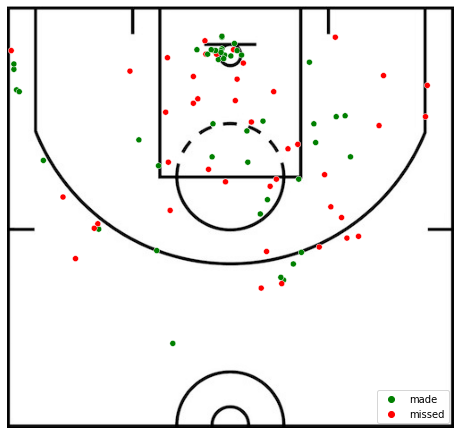

In [279]:
def plot_shotchart(df):
    plt.figure(figsize=(8,8))
    plt.imshow(plt.imread('nbahalfcourt.png'))
    sns.scatterplot(x=df['left'].astype(int),y=df['top'].astype(int),hue=df['att_result'],palette=['g','r'])
    plt.legend(loc="lower right")
    plt.axis('off')

plot_shotchart(df)

In [261]:
img = requests.get('http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png')
img

<Response [200]>

Team Shot stats

In [176]:
selector = '#shooting-BRK > tr:not(.thead)'
divs = source.select(selector)
df = pd.DataFrame([{ele["data-stat"]:ele.text for ele in div} for div in divs])
df

,quarter,fg,fga,fg_pct,fg2,fg2a,fg2_pct,fg3,fg3a,fg3_pct,efg_pct,fg_ast,fg_ast_pct
0,1st,12,24,.500,8,17,.471,4,7,.571,.583,4,.333
1,2nd,10,21,.476,6,14,.429,4,7,.571,.571,8,.800
2,3rd,12,23,.522,11,17,.647,1,6,.167,.543,6,.500
3,4th,11,21,.524,8,14,.571,3,7,.429,.595,6,.545


# Plus Minus

In [248]:
match_code = '202203060BOS'
source = get_url(f'https://www.basketball-reference.com/boxscores/plus-minus/{match_code}.html')
source = BeautifulSoup(strip_html_comment(str(source)))
selector = '#content > div.plusminus > div > div > div:not(.header)'
divs = source.select(selector)

team_pm = []
for div_player,div_player_pm in zip(divs[0::2],divs[1::2]):
    player_pm = {}
    player_pm.update(re.match(r"(?P<player>.+) \(On:(?P<on>.+)\xa0· Off:(?P<off>.+)\xa0· Net: (?P<net>.+)\)",div_player.text).groupdict())
    player_pm['plus_minus'] = []
    for div in div_player_pm.select("div > div"):
        width = re.match(r"width:(?P<width>.+)px;",div['style']).groups()[0]
        pm = div.text if div.text != u"\xa0" else None
        player_pm['plus_minus'].append((width,pm))
    team_pm.append(player_pm)
pd.DataFrame(team_pm)

,player,on,off,net,plus_minus
0,Bruce Brown,0,-6,+6,"[(160, +1), (204, None), (119, +1), (14, None)..."
1,Seth Curry,+1,-7,+8,"[(161, +1), (181, None), (157, +1), (165, +1),..."
2,Andre Drummond,-8,+2,-10,"[(129, 0), (121, None), (114, -4), (135, None)..."
3,Kevin Durant,-3,-3,0,"[(189, -1), (130, None), (180, +3), (250, -1),..."
4,Kyrie Irving,-5,-1,-4,"[(129, 0), (67, None), (53, +6), (89, -4), (92..."
5,LaMarcus Aldridge,+2,-8,+10,"[(134, None), (115, +5), (181, None), (68, -1)..."
6,Goran Dragić,-7,+1,-8,"[(134, None), (115, +5), (90, -4), (328, None)..."
7,James Johnson,-2,-4,+2,"[(171, None), (79, +4), (65, -6), (685, None)]"
8,Patty Mills,-6,0,-6,"[(170, None), (78, +4), (65, -6), (360, None),..."
9,Nic Claxton,-4,-2,-2,"[(317, None), (106, +4), (63, None), (9, 0), (..."
